In [1]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# parameters
n_grids = 350 # number of grid in grid search
R = 500 # number of Monte Carlo steps

def set_parameters(r1, r2):
  global N, M, const
  N = len(r1) # sample size of F
  M = len(r2) # sample size of G
  const = ((N*M/(N+M))**0.5)

def create_grids(r1, r2):
  global income
  _min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
  _max = np.max([np.max(r1), np.max(r2)])
  income = np.linspace(_min, _max, n_grids) # grids

def draw_random_multipliers():
  global U1_tensor, U2_tensor
  U1 = stats.norm.rvs(size=(N, R))/100
  U1_tensor = tf.constant(np.repeat(U1[None, ...], n_grids, 0)) # repeat for grid search dimension

  U2 = stats.norm.rvs(size=(M, R))/100
  U2_tensor = tf.constant(np.repeat(U2[None, ...], n_grids, 0)) # repeat for grid search dimension

def create_tensors(r1, r2):
  global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
  income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
  income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
  # income_N_tensor[0,0,0] == income_N_tensor[0,1,0] is True 
  # income_N_tensor[0,0,0] == income_N_tensor[0,0,1] is True 

  income_M_tensor = np.repeat(income[..., None], M, 1)
  income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

  r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
  r1_tensor = np.repeat(r1_tensor[..., None], R, 2) # repeat for MC dimension
  r1_tensor = tf.constant(r1_tensor)

  r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
  r2_tensor = np.repeat(r2_tensor[..., None], R, 2)
  r2_tensor = tf.constant(r2_tensor)


In [3]:
# Simple Numpy operation for S_hat 
def empirical_I(z, x, j):
    # x: one observation of the sample
    return (x <= z)*(z-x)**(j-1)/np.math.factorial(j-1)

def I(z, X, j):
    # Whole sample
    N = len(X)
    return 1/N*np.sum((X <= z)*(z-X)**(j-1))/np.math.factorial(j-1)

# Compute S_hat for given incomes r1 and r2
def S_hat_fn(r1, r2, j):
  global const, income
  fn = lambda z: (I(z, r2, j) - I(z, r1, j))
  a = np.array([fn(i) for i in income])
  S_hat = const*np.max(a)
  return S_hat


In [4]:
# Make functions for Numpy adapt for Tensorflow Tensor
def empirical_I_tf(z, x, j):
    # x: one observation of the sample
    return tf.cast((x <= z), tf.float64)*tf.math.add(z, -x)**(j-1)/np.math.factorial(j-1)

def I_tf(z, X, j, N):
    # Whole sample
    A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
    A = tf.math.reduce_sum(A, axis=1, keepdims=True)
    A = tf.repeat(A, N, axis=1)
    return ((1/N)*A/np.math.factorial(j-1)).numpy()

def S_bar_fn(j):
  global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
  a = empirical_I_tf(income_N_tensor, r1_tensor, j)
  b = I_tf(income_N_tensor, r1_tensor, j, N)

  c = empirical_I_tf(income_M_tensor, r2_tensor, j)
  d = I_tf(income_M_tensor, r2_tensor, j, M)
  
  e = ((c-d)*U2_tensor) - ((a-b)*U1_tensor)
  f = tf.math.reduce_sum(e, axis=1)

  S_bar = const*tf.math.reduce_max(f, axis=0)
  return S_bar

In [5]:
def make_decision(S_bar, S_hat):
  p = np.mean(S_bar > S_hat) 
  print('P-value =', p)

  if p < 0.10:
    print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
    return 1
  else:
    print("Cannot reject Null; r2 is domaining r1 OR r2==r1")
    return 0



In [6]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# import pickle
# with open('/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
#     results = pickle.load(handle)

# Local
import pickle
with open('../Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
    results = pickle.load(handle)

0.938244563326645 1.4168554251261236


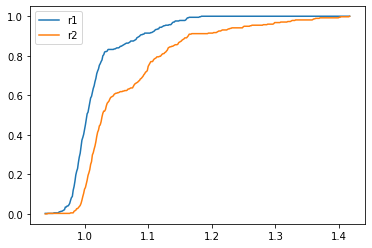

In [27]:
# two incomes
# r1 = (stats.t.rvs(df=10, size=350)*0.8)+3
# r2 = (stats.t.rvs(df=10, size=350)*1.2)+3.1

r1 = np.array(results[('Gumbel'), ('VaR q=0.05')])
# r2 = np.array(results[('Frank'), ('VaR q=0.05')])
r2 = np.array(results[('Frank'), ('VaR q=0.05')])


ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label='r1')
plt.plot(x, ecdf2(x), label='r2')
plt.legend()

# test for SOSD
j = 1

0.0
P-value = 0.998
Cannot reject Null; r2 is domaining r1 OR r2==r1


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

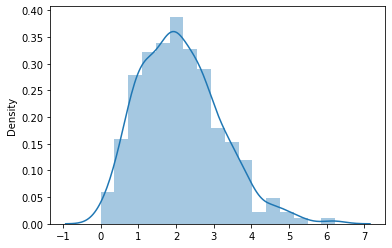

In [16]:
try:
  del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
except: 
  pass

set_parameters(r1, r2)
create_grids(r1, r2)
S_hat = S_hat_fn(r1, r2, j)

draw_random_multipliers()
create_tensors(r1, r2)
S_bar = S_bar_fn(j)
print(S_hat)
H = make_decision(S_bar, S_hat)

sns.distplot(S_bar)

7.229937759068194
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

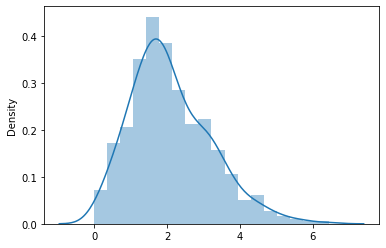

In [17]:
del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 

set_parameters(r2, r1)
create_grids(r2, r1)
S_hat = S_hat_fn(r2, r1, j)

draw_random_multipliers()
create_tensors(r2, r1)
S_bar = S_bar_fn(j)
print(S_hat)
make_decision(S_bar, S_hat)

sns.distplot(S_bar)

In [13]:
S_hat_fn(r1,r2,2)

0.11687129897798809

In [14]:
S_hat_fn(r2,r1,2)

0.0

In [15]:
def run(r1, r2, j):
  try:
    del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
  except: 
    pass
    
  set_parameters(r1, r2)
  create_grids(r1, r2)
  S_hat = S_hat_fn(r1, r2, j)

  draw_random_multipliers()
  create_tensors(r1, r2)
  S_bar = S_bar_fn(j)
  print(S_hat)
  H = make_decision(S_bar, S_hat)
  return H

In [16]:
run(r1,r2,2)

0.11687129897798809
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2


1

In [17]:
run(r2,r1,2)

0.0
P-value = 0.848
Cannot reject Null; r2 is domaining r1 OR r2==r1


0

In [26]:
CR_pairs = list(results.keys())[:10]

In [27]:
print("Totle number of operation is", len(CR_pairs)**2)

SOSD = np.ones([len(CR_pairs), len(CR_pairs)])+1000
SOSD = pd.DataFrame(SOSD, index=CR_pairs, columns=CR_pairs)
save_file = '/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/SOSD.pickle'
for i, pair1 in enumerate(CR_pairs):
  for k, pair2 in enumerate(CR_pairs):
    if k<i:
      pass 
    else:
      r1 = np.array(results[pair1])
      r2 = np.array(results[pair2])
      SOSD.iloc[i,k] = run(r1, r2, j=2)
      SOSD.iloc[k,i] = run(r2, r1, j=2)

      if (k%10 == 0):
        with open(save_file, 'wb') as handle:
          pickle.dump(SOSD, handle)
        print(i,k)


Totle number of operation is 100
0.0
P-value = 0.848
Cannot reject Null; r2 is domaining r1 OR r2==r1
0.0
P-value = 0.866
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 0
0.6061981471626152
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
0.0
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 1
0.07212764126453387
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9.361951528187605e-05
P-value = 0.69
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 2
0.0
P-value = 0.864
Cannot reject Null; r2 is domaining r1 OR r2==r1
0.033079540126979855
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
0 3
0.0
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
0.41553286091755426
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
0 4
0.0
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
0.10568051699672909
P-value = 0.0
Re

KeyboardInterrupt: ignored

0.8755050911574485 1.1242429199677781


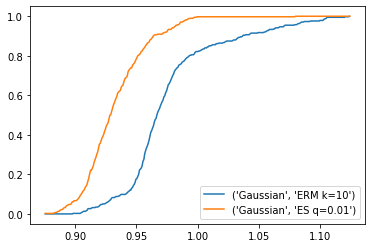

In [168]:
r1 = results[CR_pairs[0]]
r2 = results[CR_pairs[1]]
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label=CR_pairs[0])
plt.plot(x, ecdf2(x), label=CR_pairs[1])
plt.legend()

In [20]:
import pandas as pd


In [22]:
SOSD

,"(Gaussian, ERM k=10)","(Gaussian, ES q=0.01)","(Gaussian, ES q=0.05)"
"(Gaussian, ERM k=10)",0.0,1.0,1.0
"(Gaussian, ES q=0.01)",0.0,0.0,0.0
"(Gaussian, ES q=0.05)",0.0,1.0,0.0


In [ ]:
SOSD.to_pickle('/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/SOSD.pkl')

In [183]:
pd.__version__

'1.1.5'